In [1]:
import pandas as pd
# import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
import numpy as np



In [2]:
# загружаем данные

df = pd.read_excel('Analytic_test.xlsx', header=1, usecols='B:Y')
df.rename(columns={'active_Red':'has_Red_id'}, inplace=True)
df.head()

,HID,has_Red_id,has_Green_id,has_Black_id,has_Blue_id,Blue_activity_count,Blue_gmv_total,Green_gvm_total,Green_gvm_order_count,Black_gvm_total,...,Blue_android,Red_apple,Green_apple,Black_apple,Blue_apple,is_msk,Red_web,Green_web,Black_web,Blue_web
0,00003c7fb5e57ce673f1801f3679f5c25,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00006b602533083e3bebfcbff08613931,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0000736c3f76339196cb1cc759b8363b,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00009bdcc5307b38efde8690b8bd658e,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0000bc3186b7b31d9b35d3fbbb250b9f8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
# посмотрим что за типы данных представлены в таблице

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 24 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   HID                    100000 non-null  object 
 1   has_Red_id             100000 non-null  float64
 2   has_Green_id           100000 non-null  float64
 3   has_Black_id           100000 non-null  float64
 4   has_Blue_id            100000 non-null  float64
 5   Blue_activity_count    100000 non-null  object 
 6   Blue_gmv_total         100000 non-null  object 
 7   Green_gvm_total        100000 non-null  float64
 8   Green_gvm_order_count  100000 non-null  object 
 9   Black_gvm_total        100000 non-null  float64
 10  Black_gvm_order_count  100000 non-null  object 
 11  Red_android            100000 non-null  float64
 12  Green_android          100000 non-null  float64
 13  Black_android          100000 non-null  float64
 14  Blue_android           100000 non-nul

In [4]:
# перевдим данные к числовому типу в следующих колонках

for col in df.columns[1:]:
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [5]:
#проевряем пропуски и количество уникальных id, после того как привели значения к числовому типу

print(f'Количество уникальных HID: {df.HID.nunique()}\nКоличество полей в таблиц: {df.shape[0]}\n')

print(f'Суммарное количество пропусков в таблице: \n{df.isnull().sum().sum()}')

# так как все указанные пользователи - уникальные, информацию HID - можно удалить

df.drop(columns='HID', inplace=True)

Количество уникальных HID: 100000
Количество полей в таблиц: 100000

Суммарное количество пропусков в таблице: 
14


In [6]:
hyp = df.copy(deep=True)
hyp.head()
hyp['numb_registration'] = hyp[['has_Red_id',	'has_Green_id',	'has_Black_id',	'has_Blue_id']].sum(axis=1)
display(hyp['numb_registration'].value_counts().sort_values(ascending=False))

# откуда может возникнуть количество регистраций 5, если всего представлено компаний - 4

hyp.query('numb_registration==5')[['has_Red_id',	'has_Green_id',	'has_Black_id',	'has_Blue_id', 'numb_registration']]

#это связяно с тем, что у пользователя может быть несколько регистраций в рамках одной компании

1.0    52491
0.0    38354
2.0     8358
3.0      750
4.0       43
5.0        4
Name: numb_registration, dtype: int64

,has_Red_id,has_Green_id,has_Black_id,has_Blue_id,numb_registration
798,1.0,1.0,1.0,2.0,5.0
30689,1.0,1.0,1.0,2.0,5.0
56589,1.0,0.0,0.0,4.0,5.0
92449,1.0,0.0,0.0,4.0,5.0


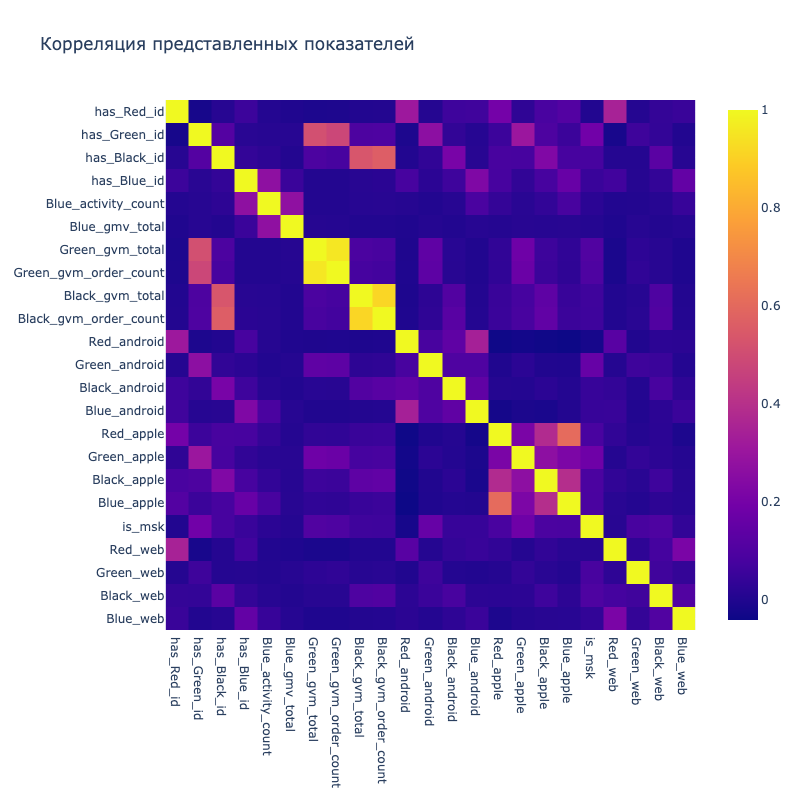

In [7]:
# построим матрицу корреляции, для рассмотрения зависимости признаков между различными компаниями

fig = px.imshow(df.corr(),width=800, height=800, title='Корреляция представленных показателей')
fig.show('png')


#### По этому графику корреляции мы можем заметить довольно выраженную корреляцию (0.61) колличества установленных приложений для **Apple** среди компаний **Blue** и **Red**.

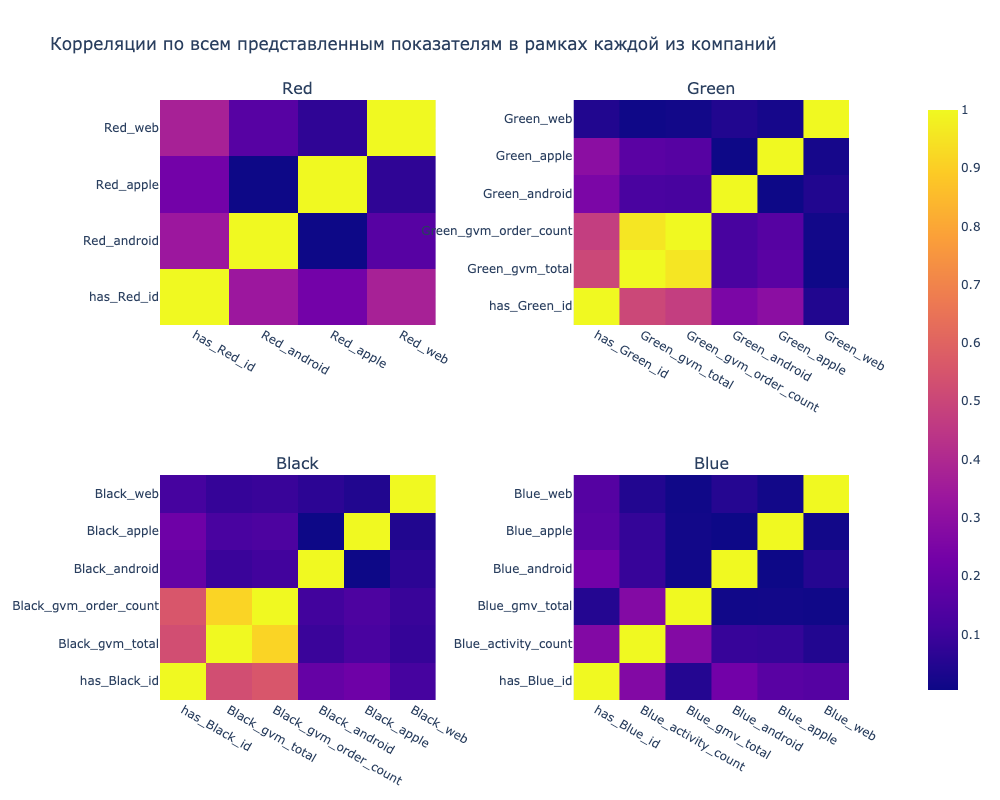

In [8]:
# рассмотерим корреляции по всем представленным показателям в рамках каждой из компаний

companies = ['Red', 'Green', 'Black', 'Blue']
fig = make_subplots(rows=2, cols=2, subplot_titles=companies,horizontal_spacing=0.20)
for i, company in enumerate(companies):
    sub_df = df.filter(like=company)
    corr_matrix = sub_df.corr()
    fig.add_trace(go.Heatmap(z=corr_matrix, x=corr_matrix.columns, y=corr_matrix.index, colorbar_x=1.1), row=int(i/2)+1, col=i%2+1)
    if i!=3:
        fig.update_traces(showscale=False)
fig.update_layout(width=1000, height=800, title='Корреляции по всем представленным показателям в рамках каждой из компаний')

fig.show('png')

#### Наибольшие корреляции (0.51 и 0.53) наблюдаются в компаниях **Green** и **Black** соответственно, между *количеством регистраций* клиентов и *количеством успешных заказов, а также успешных действий пользователей*

In [9]:
# сгруппируем пользователей по параметру 'is_msk'

grouped_df = df.groupby('is_msk', as_index=True).sum()
grouped_df

,has_Red_id,has_Green_id,has_Black_id,has_Blue_id,Blue_activity_count,Blue_gmv_total,Green_gvm_total,Green_gvm_order_count,Black_gvm_total,Black_gvm_order_count,...,Black_android,Blue_android,Red_apple,Green_apple,Black_apple,Blue_apple,Red_web,Green_web,Black_web,Blue_web
is_msk,,,,,,,,,,,,,,,,,,,,,
0.0,49202.0,207.0,696.0,11591.0,17139.0,183480.0,1155986.0,1507.0,4997172.0,2422.0,...,800.0,6702.0,8753.0,89.0,1197.0,3510.0,58892.0,58.0,918.0,9026.0
1.0,6672.0,683.0,388.0,2210.0,3869.0,62634.0,4837434.0,6192.0,4490136.0,1963.0,...,277.0,1345.0,2121.0,527.0,585.0,1136.0,8216.0,140.0,543.0,1614.0


In [10]:
# Получим отдельные датафремы по каждой из компаний

df_red = grouped_df.filter(like='Red')
df_green = grouped_df.filter(like='Green')
df_black = grouped_df.filter(like='Black')
df_blue = grouped_df.filter(like='Blue')
for data in [df_red, df_green, df_black, df_blue]:
	display(data)
	


,has_Red_id,Red_android,Red_apple,Red_web
is_msk,,,,
0.0,49202.0,28614.0,8753.0,58892.0
1.0,6672.0,3519.0,2121.0,8216.0


,has_Green_id,Green_gvm_total,Green_gvm_order_count,Green_android,Green_apple,Green_web
is_msk,,,,,,
0.0,207.0,1155986.0,1507.0,101.0,89.0,58.0
1.0,683.0,4837434.0,6192.0,445.0,527.0,140.0


,has_Black_id,Black_gvm_total,Black_gvm_order_count,Black_android,Black_apple,Black_web
is_msk,,,,,,
0.0,696.0,4997172.0,2422.0,800.0,1197.0,918.0
1.0,388.0,4490136.0,1963.0,277.0,585.0,543.0


,has_Blue_id,Blue_activity_count,Blue_gmv_total,Blue_android,Blue_apple,Blue_web
is_msk,,,,,,
0.0,11591.0,17139.0,183480.0,6702.0,3510.0,9026.0
1.0,2210.0,3869.0,62634.0,1345.0,1136.0,1614.0


In [11]:
# функция которая переименует колонки, чтобы привести данные о компаниях к общему виду
# и при этом исправим ряд полей, названия которых указаны с ошибкой (относительно вводных)

def rename_cols(data):
    data.rename(columns={
    'Black_android': 'android',
    'Black_apple': 'apple',
    'Black_web': 'web',
    'Black_gvm_total': 'gmv_total',
    'Black_gvm_order_count': 'gvm_order_count',
    'Blue_activity_count': 'activity_count',
    'Blue_android': 'android',
    'Blue_apple': 'apple',
    'Blue_gmv_total': 'gmv_total',
    'Blue_web': 'web',
    'Green_android': 'android',
    'Green_apple': 'apple',
    'Green_gvm_total': 'gmv_total',
    'Green_gvm_order_count': 'gvm_order_count',
    'Green_web': 'web',
    'Red_android': 'android',
    'Red_apple': 'apple',
    'Red_web': 'web',
    'has_Black_id': 'has_id',
    'has_Blue_id': 'has_id',
    'has_Green_id': 'has_id',
    'has_Red_id': 'has_id'
}, inplace=True)
    

In [12]:

for company, data in zip(['Red','Green', 'Black', 'Blue'],[df_red, df_green, df_black, df_blue]):
    rename_cols(data)
    data['company'] = company
    data.index.names = ['is_msk']
    display(data)	

/var/folders/wk/f7xb8jbs2f95g5mv_2cpn6hh0000gn/T/ipykernel_76789/2273863676.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/wk/f7xb8jbs2f95g5mv_2cpn6hh0000gn/T/ipykernel_76789/3248157946.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,has_id,android,apple,web,company
is_msk,,,,,
0.0,49202.0,28614.0,8753.0,58892.0,Red
1.0,6672.0,3519.0,2121.0,8216.0,Red


/var/folders/wk/f7xb8jbs2f95g5mv_2cpn6hh0000gn/T/ipykernel_76789/2273863676.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/wk/f7xb8jbs2f95g5mv_2cpn6hh0000gn/T/ipykernel_76789/3248157946.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,has_id,gmv_total,gvm_order_count,android,apple,web,company
is_msk,,,,,,,
0.0,207.0,1155986.0,1507.0,101.0,89.0,58.0,Green
1.0,683.0,4837434.0,6192.0,445.0,527.0,140.0,Green


/var/folders/wk/f7xb8jbs2f95g5mv_2cpn6hh0000gn/T/ipykernel_76789/2273863676.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/wk/f7xb8jbs2f95g5mv_2cpn6hh0000gn/T/ipykernel_76789/3248157946.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,has_id,gmv_total,gvm_order_count,android,apple,web,company
is_msk,,,,,,,
0.0,696.0,4997172.0,2422.0,800.0,1197.0,918.0,Black
1.0,388.0,4490136.0,1963.0,277.0,585.0,543.0,Black


/var/folders/wk/f7xb8jbs2f95g5mv_2cpn6hh0000gn/T/ipykernel_76789/2273863676.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/wk/f7xb8jbs2f95g5mv_2cpn6hh0000gn/T/ipykernel_76789/3248157946.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,has_id,activity_count,gmv_total,android,apple,web,company
is_msk,,,,,,,
0.0,11591.0,17139.0,183480.0,6702.0,3510.0,9026.0,Blue
1.0,2210.0,3869.0,62634.0,1345.0,1136.0,1614.0,Blue


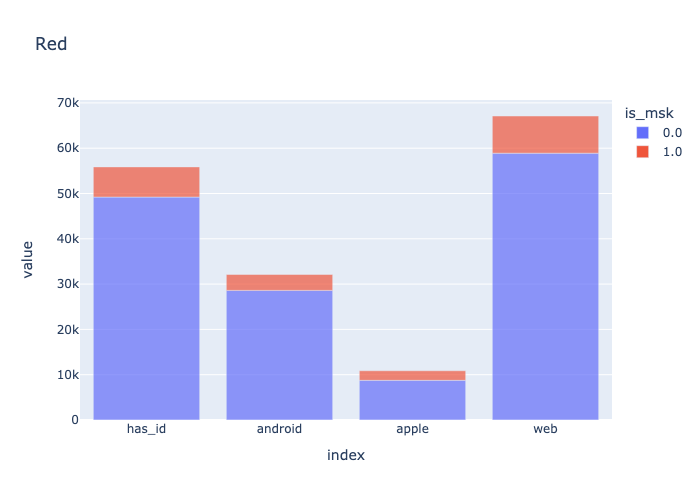

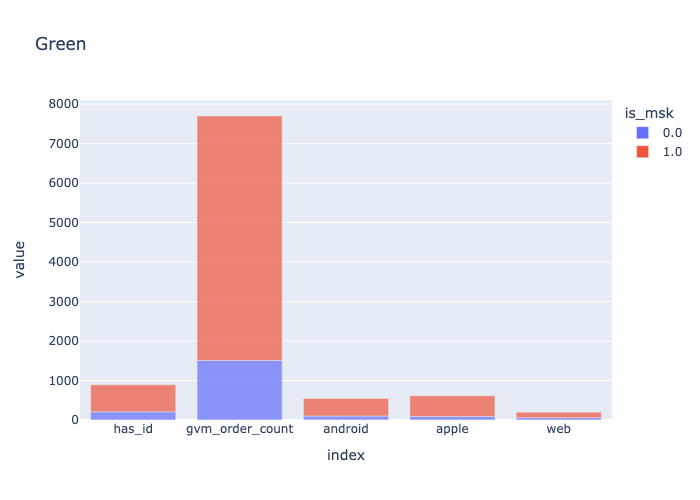

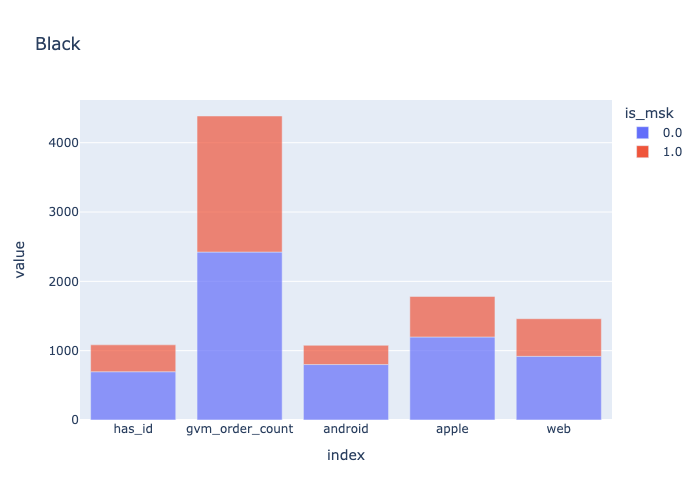

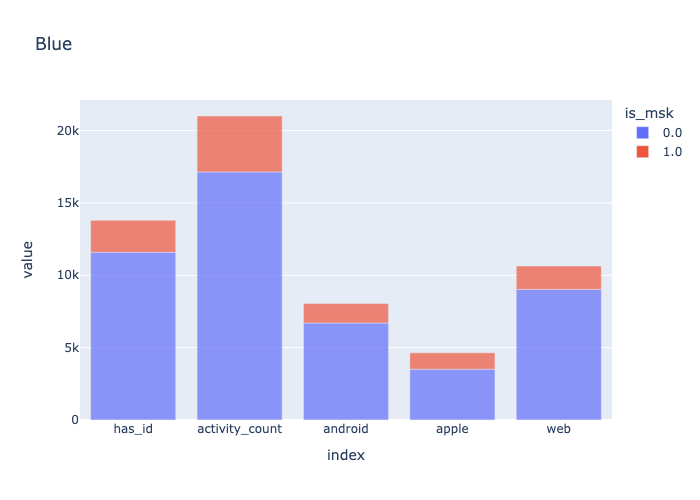

In [13]:
# рассмотрим графики для сравнения показателей характерных для Москвы и регионов

df_companies = [df_red, df_green, df_black, df_blue]

def bar_by_region(data, title):
    fig = px.bar(data_frame=data.loc[:,~data.columns.isin(['gmv_total','company'])].T, title=title, opacity=0.7)
    fig.show('png')

for company_name, data in zip(['Red','Green', 'Black', 'Blue'], df_companies):
    bar_by_region(data, company_name)

#### По количеству заказов и количеству регистраций, на этом графике прекрасно видно, что большинство пользователей компании **Green** представлено в Москве.

In [14]:
res_df = pd.concat([df_red, df_green, df_black, df_blue], axis=0).sort_values('web', ascending=False)
display(res_df)

,has_id,android,apple,web,company,gmv_total,gvm_order_count,activity_count
is_msk,,,,,,,,
0.0,49202.0,28614.0,8753.0,58892.0,Red,NaN,NaN,NaN
0.0,11591.0,6702.0,3510.0,9026.0,Blue,183480.0,NaN,17139.0
1.0,6672.0,3519.0,2121.0,8216.0,Red,NaN,NaN,NaN
1.0,2210.0,1345.0,1136.0,1614.0,Blue,62634.0,NaN,3869.0
0.0,696.0,800.0,1197.0,918.0,Black,4997172.0,2422.0,NaN
1.0,388.0,277.0,585.0,543.0,Black,4490136.0,1963.0,NaN
1.0,683.0,445.0,527.0,140.0,Green,4837434.0,6192.0,NaN
0.0,207.0,101.0,89.0,58.0,Green,1155986.0,1507.0,NaN


Тут мы как раз видим, что данные в полях *gmv_total*, *gvm_order_count*, *activity_count* отсутствуют для некоторых компаний (в изначальной таблице таких полей не было), поэтому сравнить получится только среди представленных показателей 

In [15]:
# теперь разделим данные по отдельности на москву, регионы, и всех суммарно

df_msk = res_df.query('is_msk == 1').set_index('company').sort_values(axis=1, by=companies, ascending=False)
df_regions = res_df.query('is_msk == 0').set_index('company').sort_values(axis=1,by=companies, ascending=False)
# df_total = res_df.groupby('company').sum(min_count=1)
display(df_msk)
display(df_regions)
# display(df_total)

,web,has_id,android,apple,gmv_total,gvm_order_count,activity_count
company,,,,,,,
Red,8216.0,6672.0,3519.0,2121.0,NaN,NaN,NaN
Blue,1614.0,2210.0,1345.0,1136.0,62634.0,NaN,3869.0
Black,543.0,388.0,277.0,585.0,4490136.0,1963.0,NaN
Green,140.0,683.0,445.0,527.0,4837434.0,6192.0,NaN


,web,has_id,android,apple,gmv_total,gvm_order_count,activity_count
company,,,,,,,
Red,58892.0,49202.0,28614.0,8753.0,NaN,NaN,NaN
Blue,9026.0,11591.0,6702.0,3510.0,183480.0,NaN,17139.0
Black,918.0,696.0,800.0,1197.0,4997172.0,2422.0,NaN
Green,58.0,207.0,101.0,89.0,1155986.0,1507.0,NaN


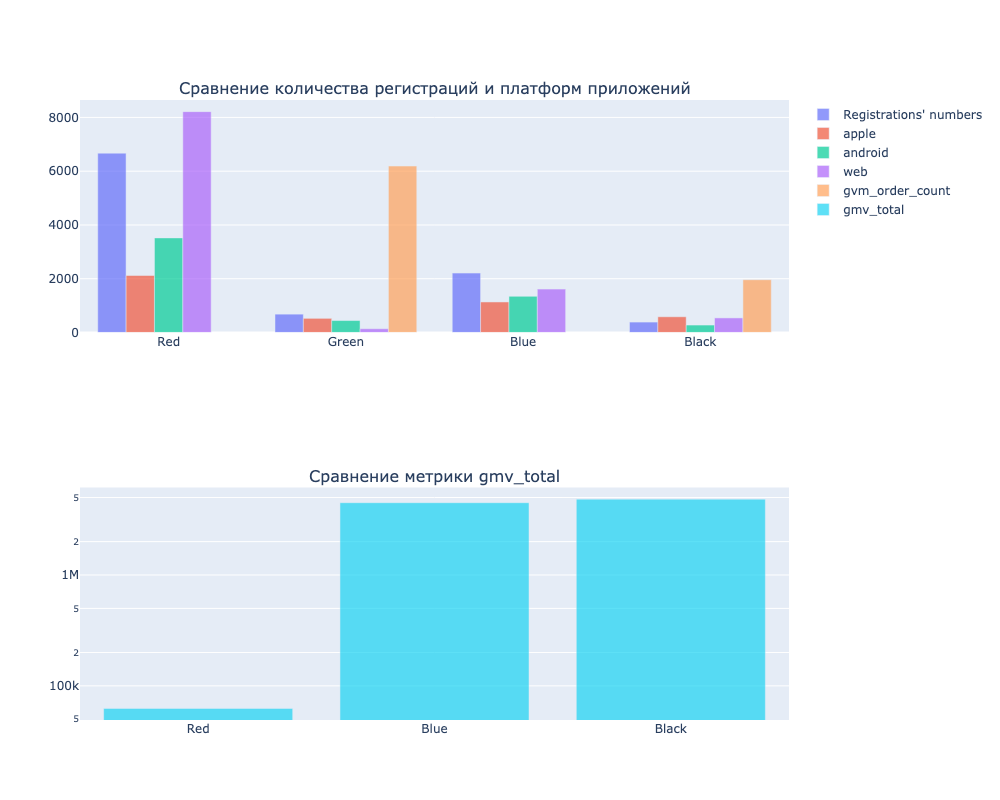

In [16]:
fig = make_subplots(rows=2, cols=1, subplot_titles=('Сравнение количества регистраций и платформ приложений','Сравнение метрики gmv_total'))

fig.add_trace(go.Bar(
    x=df_msk.index,
    y=df_msk['has_id'],
    showlegend=True,opacity=0.7, name="Registrations' numbers"),row=1,col=1,secondary_y=False)
# fig.update_layout(xaxis={'categoryorder': 'total descending'})

fig.add_trace(go.Bar(
    x=df_msk.index,
    y=df_msk['apple'],
    showlegend=True,opacity=0.7, name='apple'),row=1,col=1,secondary_y=False)
fig.add_trace(go.Bar(
    x=df_msk.index,
    y=df_msk['android'],
    showlegend=True,opacity=0.7, name='android'),row=1,col=1,secondary_y=False)
fig.add_trace(go.Bar(
    x=df_msk.index,
    y=df_msk['web'],
    showlegend=True,opacity=0.7, name='web'),row=1,col=1,secondary_y=False)
fig.add_trace(go.Bar(
    x=df_msk.index,
    y=df_msk['gvm_order_count'],
    showlegend=True,opacity=0.7, name='gvm_order_count'),row=1,col=1,secondary_y=False)
fig.update_layout(xaxis={'categoryorder': 'total descending'})

fig.add_trace(go.Bar(
    x=df_msk.index,
    y=df_msk['gmv_total'].dropna(),
    showlegend=True,opacity=0.7, name='gmv_total'),row=2,col=1,secondary_y=False)
fig.update_yaxes(type="log", row=2, col=1)

fig.update_layout(yaxis=dict(categoryorder="total descending"), width=1000, height=800)
fig.show('png')

По первому графику для компании **Green** наблюдается наибольшее отношение количества заказов к количеству зарегистрированных пользователей.

In [17]:
print(f'Отношение количества успешных заказов к количеству зарегистрированных пользователей: {df_msk.loc["Green","gvm_order_count"]/df_msk.loc["Green","has_id"]}')

Отношение количества успешных заказов к количеству зарегистрированных пользователей: 9.06588579795022


In [18]:
def plot_by_index(data, title_type):
    fig = px.bar(data[['apple','android','web', 'has_id','gvm_order_count']].T,
                #  y='value',
                title=f"Сравнительная диаграмма суммарных показателей для {title_type}",
                barmode='group',
                height=600,
                color_discrete_map={
            'Red': 'red',
            'Blue': 'blue',
            'Green': 'green',
            'Black': 'black'
        }, opacity=0.5, labels={'value':'total numbers',
                                'index':'category'}
                
                ).update_xaxes(categoryorder="total descending")
    fig.update_layout(font_size=12, width=900, height=450)

    fig.show('png')

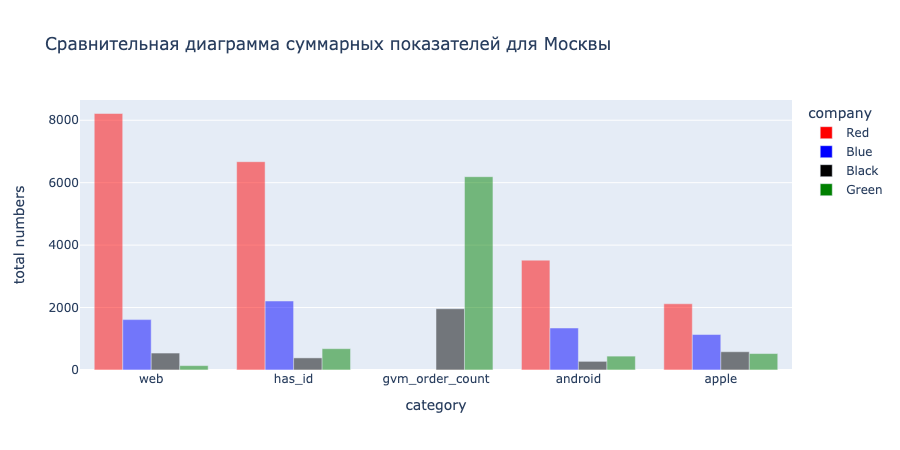

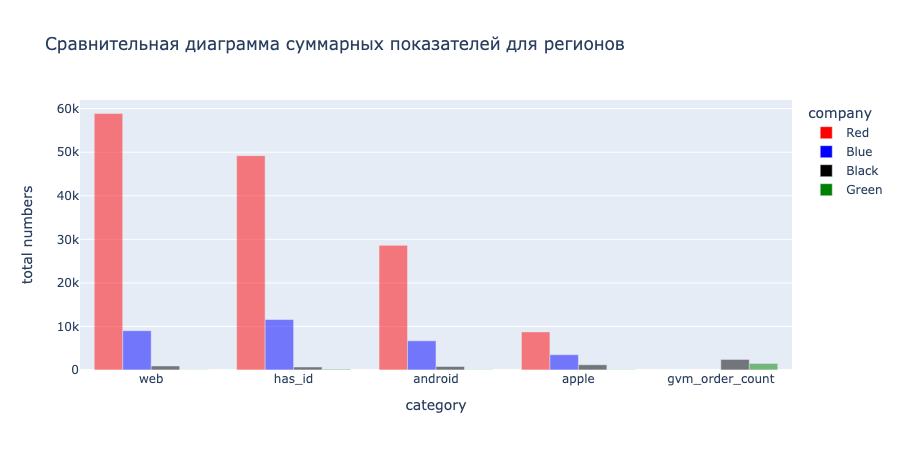

In [19]:
plot_by_index(df_msk, 'Москвы')
plot_by_index(df_regions, 'регионов')


По этим гистограммам видно, что компания **Red** является самой крупной среди представленных. Как и отмечалось ранее, компания **Green** в большинстве своем представлена в Москве

In [20]:
def plot_by_company(data, title_type):
    fig = px.bar(data[['apple','android','web', 'has_id']].rename(columns={'has_id':'registration'}),
                #  y='value',
                title=f"Распределение количества платформ в рамках каждой компании для {title_type}",
                barmode='group',
                height=600,
                color_discrete_map={
            'Red': 'red',
            'Blue': 'blue',
            'Green': 'green',
            'Black': 'black'},
                opacity=0.7, 
                labels={'value':'total numbers',
                                'index':'category',
                                'variable':'platform',}
                
                ).update_xaxes(categoryorder="total descending")
    fig.update_layout(font_size=12, width=900, height=450)
    fig.show('png')


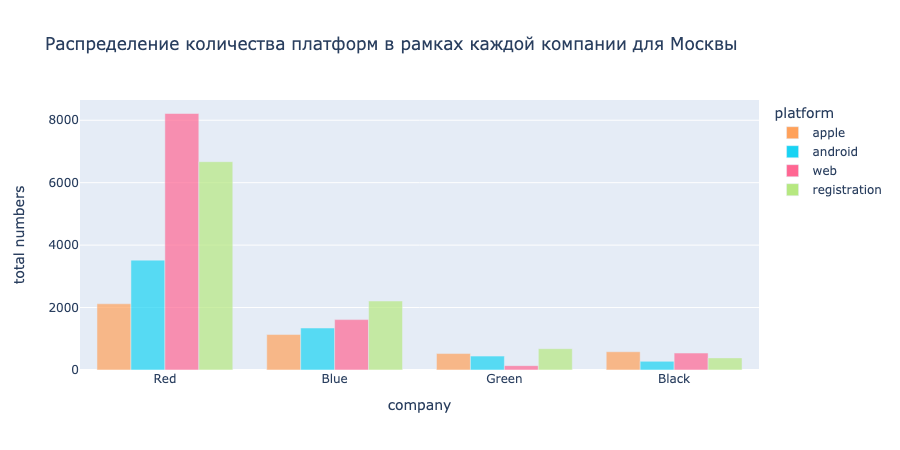

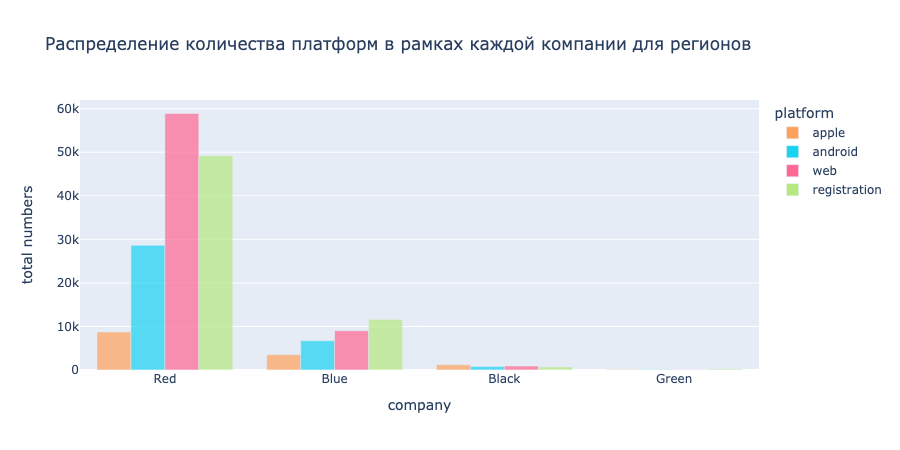

In [21]:
plot_by_company(df_msk, 'Москвы')
plot_by_company(df_regions, 'регионов')

Для компании **Red** количество пользователей ПК (web) превышает количество зарегистрированных пользователей

# Основные выводы и итоги:
- данные были предобработаны и очищены
- построена матрица корреляции представленных признаков
- построены соответствующие гистограммы распределения показателей по каждой из компаний в сравнении по регионам (параметр *is_msk*)
- несмотря на то, что компания **Red** является самой крупной (по количеству зарегистрированных пользователей), она сильно уступает другим компаниям **Blue**, **Black** по метрике *gmv_total*
- также были получены инсайты относительно компании **Green**, которая обладает наибольшим отношением количества заказов к количеству зарегистрированных пользователей $(9 \frac{заказов}{пользователя})$